In [1]:
import pandas as pd
import numpy as np
import PIL 
import pathlib
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


In [3]:
path_dict = {
    'train_data_dir_normal': r"C:\Users\aditi\OneDrive\Desktop\MINOR PROJECT\chest_xray\test\NORMAL",
    'train_data_dir_pneumonia': r"C:\Users\aditi\OneDrive\Desktop\MINOR PROJECT\chest_xray\test\PNEUMONIA",
    'test_data_dir_normal': r"C:\Users\aditi\OneDrive\Desktop\MINOR PROJECT\chest_xray\train\NORMAL",
    'test_data_dir_pneumonia': r"C:\Users\aditi\OneDrive\Desktop\MINOR PROJECT\chest_xray\test\PNEUMONIA",
    'data_val_dir_normal': r"C:\Users\aditi\OneDrive\Desktop\MINOR PROJECT\chest_xray\val\NORMAL",
    'data_val_dir_pneumonia': r"C:\Users\aditi\OneDrive\Desktop\MINOR PROJECT\chest_xray\val\PNEUMONIA"
}


In [4]:
for key, value in path_dict.items():
    path_dict[key] = pathlib.Path(value)

In [5]:
X = []
y = []

for key, value in path_dict.items():
    images = list(path_dict[key].glob('*.jpeg'))
    for img in images:
        #reading the image and coverting it into pixels
        image = cv2.imread(str(img))
        #resizing the image to standard pixels
        resized_img = cv2.resize(image, (224, 224))
        X.append(resized_img)
        if 'normal' in key:
            y.append(0) # 0 - normal
        else:
            y.append(1) # 1 - pneumonia
            
X = np.array(X)
y = np.array(y)

In [6]:
X.shape, y.shape

((2371, 224, 224, 3), (2371,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1778, 224, 224, 3), (593, 224, 224, 3), (1778,), (593,))

In [9]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
model = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPool2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(units = 128 , activation = 'relu'),
    layers.Dense(units = 2 , activation = 'softmax'),
])

model.summary()
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

C:\Users\aditi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,650 (91.20 MB)

 Trainable params: 23,907,650 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Added EarlyStopping callback to stop training if validation loss doesn't improve for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 446ms/step - accuracy: 0.6808 - loss: 3.6653 - val_accuracy: 0.9325 - val_loss: 0.1914
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 403ms/step - accuracy: 0.9458 - loss: 0.1376 - val_accuracy: 0.9646 - val_loss: 0.1337
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 410ms/step - accuracy: 0.9638 - loss: 0.0953 - val_accuracy: 0.9713 - val_loss: 0.0816
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - accuracy: 0.9834 - loss: 0.0408 - val_accuracy: 0.9696 - val_loss: 0.0835
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 450ms/step - accuracy: 0.9951 - loss: 0.0194 - val_accuracy: 0.9781 - val_loss: 0.0944


In [13]:
model.evaluate(X_test_scaled, y_test)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9795 - loss: 0.0688


[0.09444763511419296, 0.9780775904655457]

In [14]:
y_pred = model.predict(X_test)
y_pred[:5]

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [15]:
y_pred_scaled = []
y_test_scaled = []
for x in y_pred:
    if x[0] == 1:
        y_pred_scaled.append(0)
    else:
        y_pred_scaled.append(1)
for x in y_test:
    if x[0] == 1:
        y_test_scaled.append(0)
    else:
        y_test_scaled.append(1)
y_pred_scaled = np.array(y_pred_scaled)
y_test_scaled = np.array(y_test_scaled)

<Axes: >

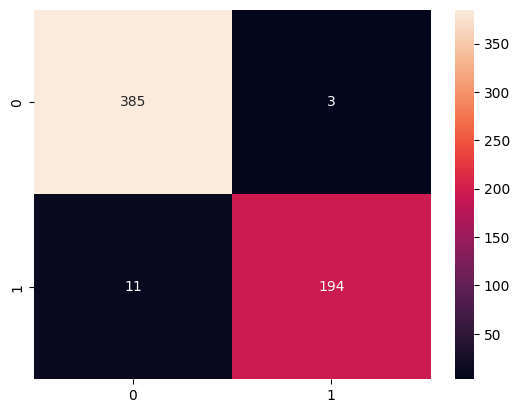

In [16]:
confusion_matrix = confusion_matrix(y_test_scaled, y_pred_scaled)
sns.heatmap(confusion_matrix, annot=True, fmt='d')

In [17]:
pip install lime


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 

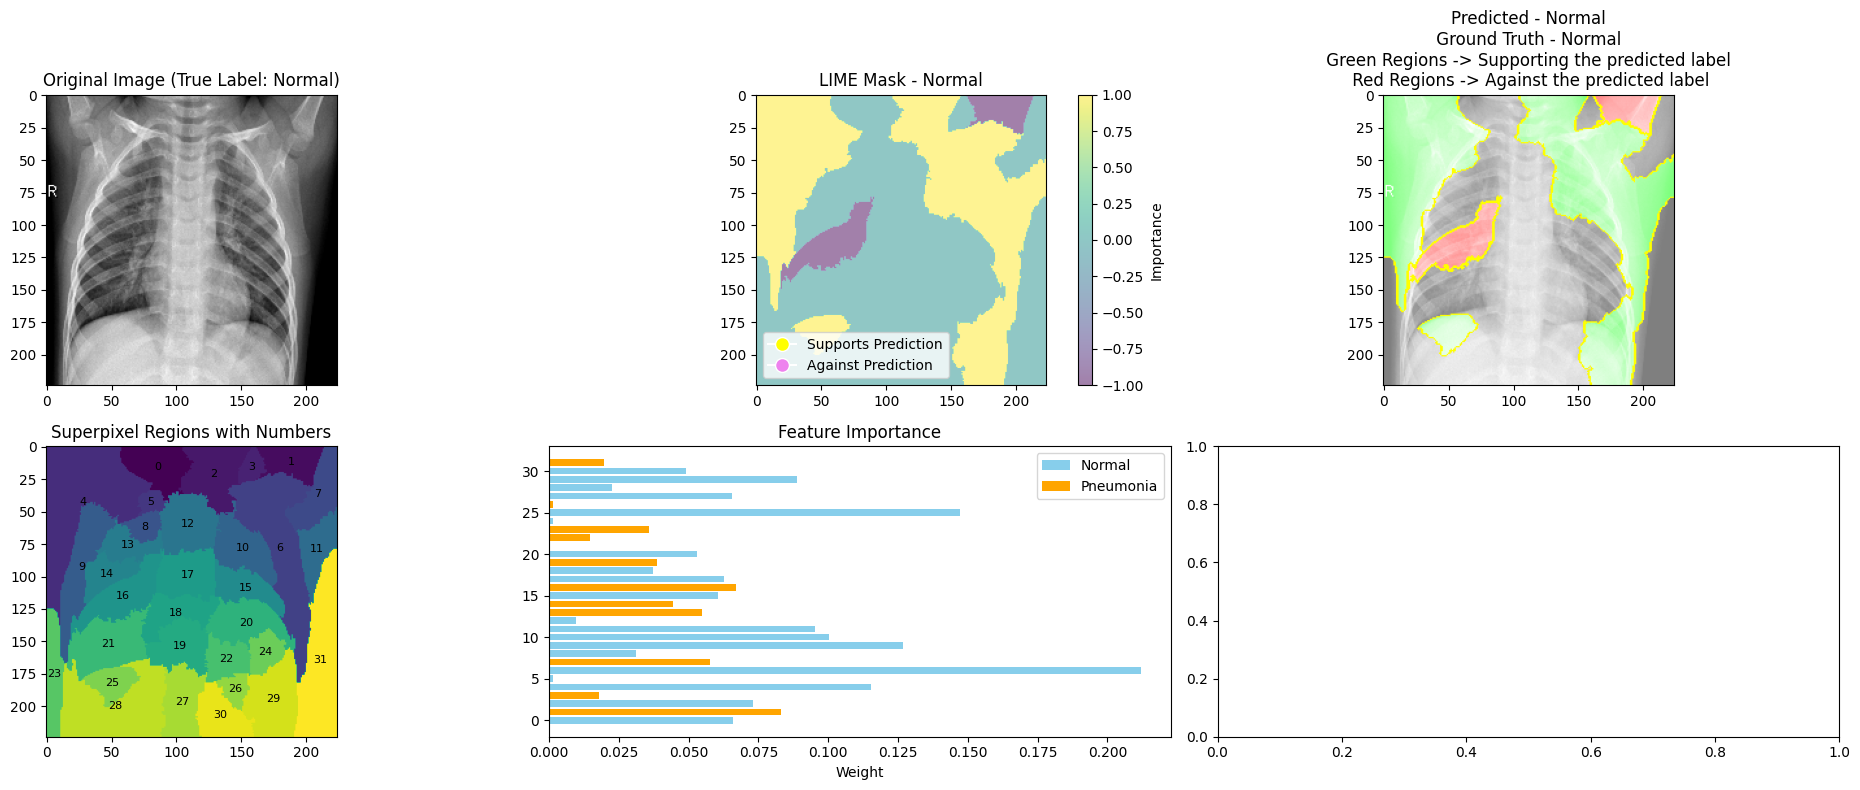

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━

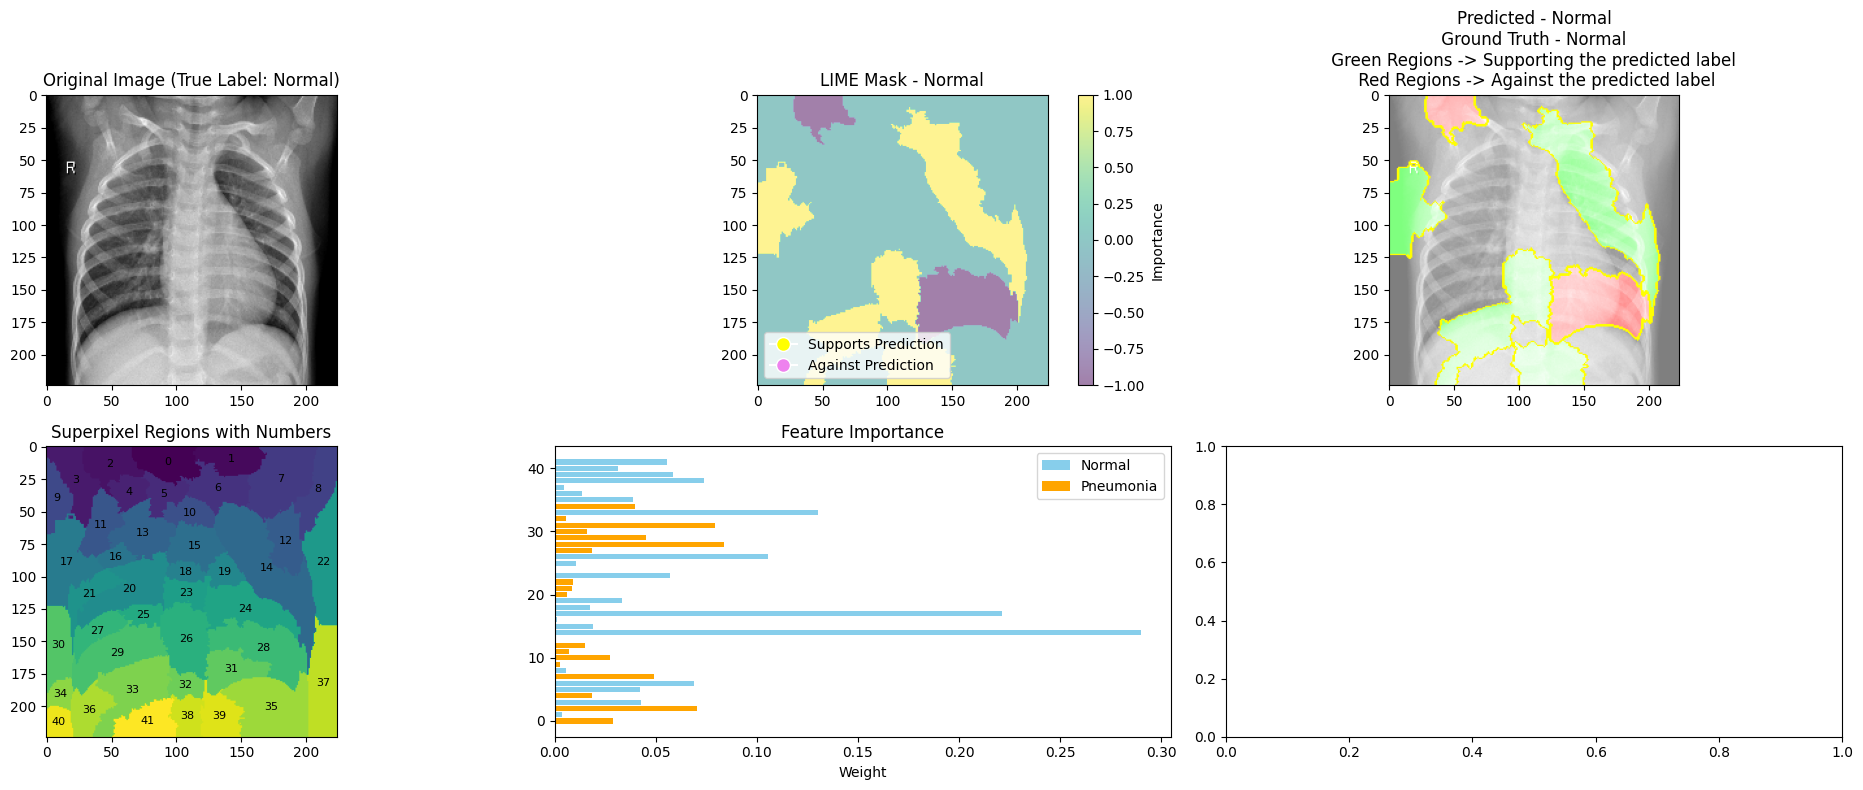

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94m

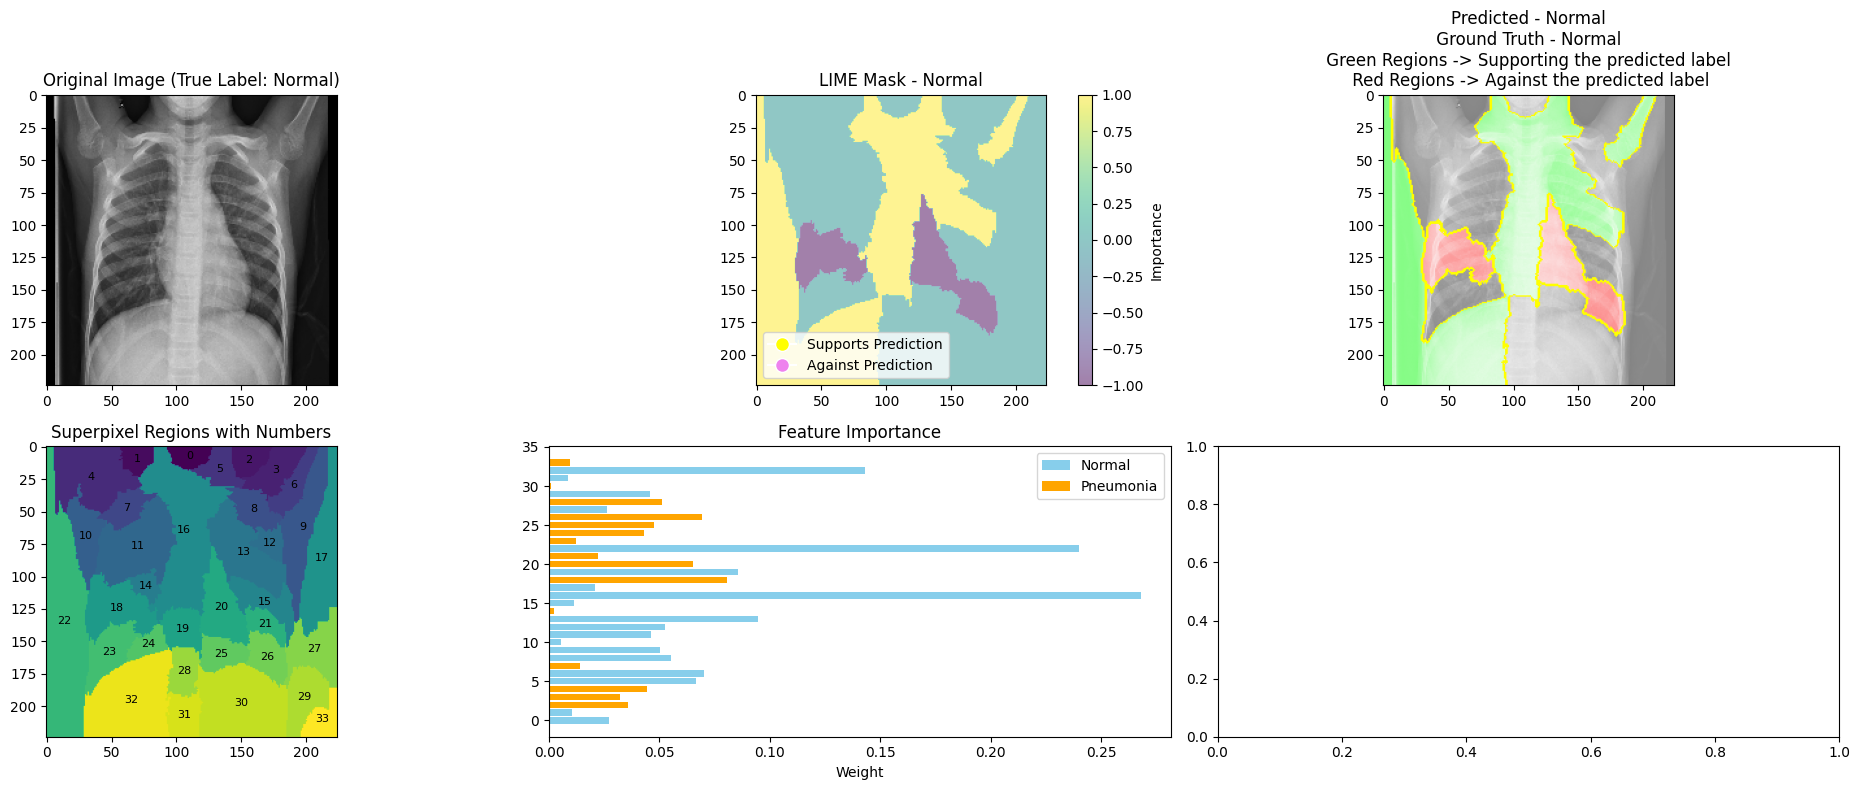

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

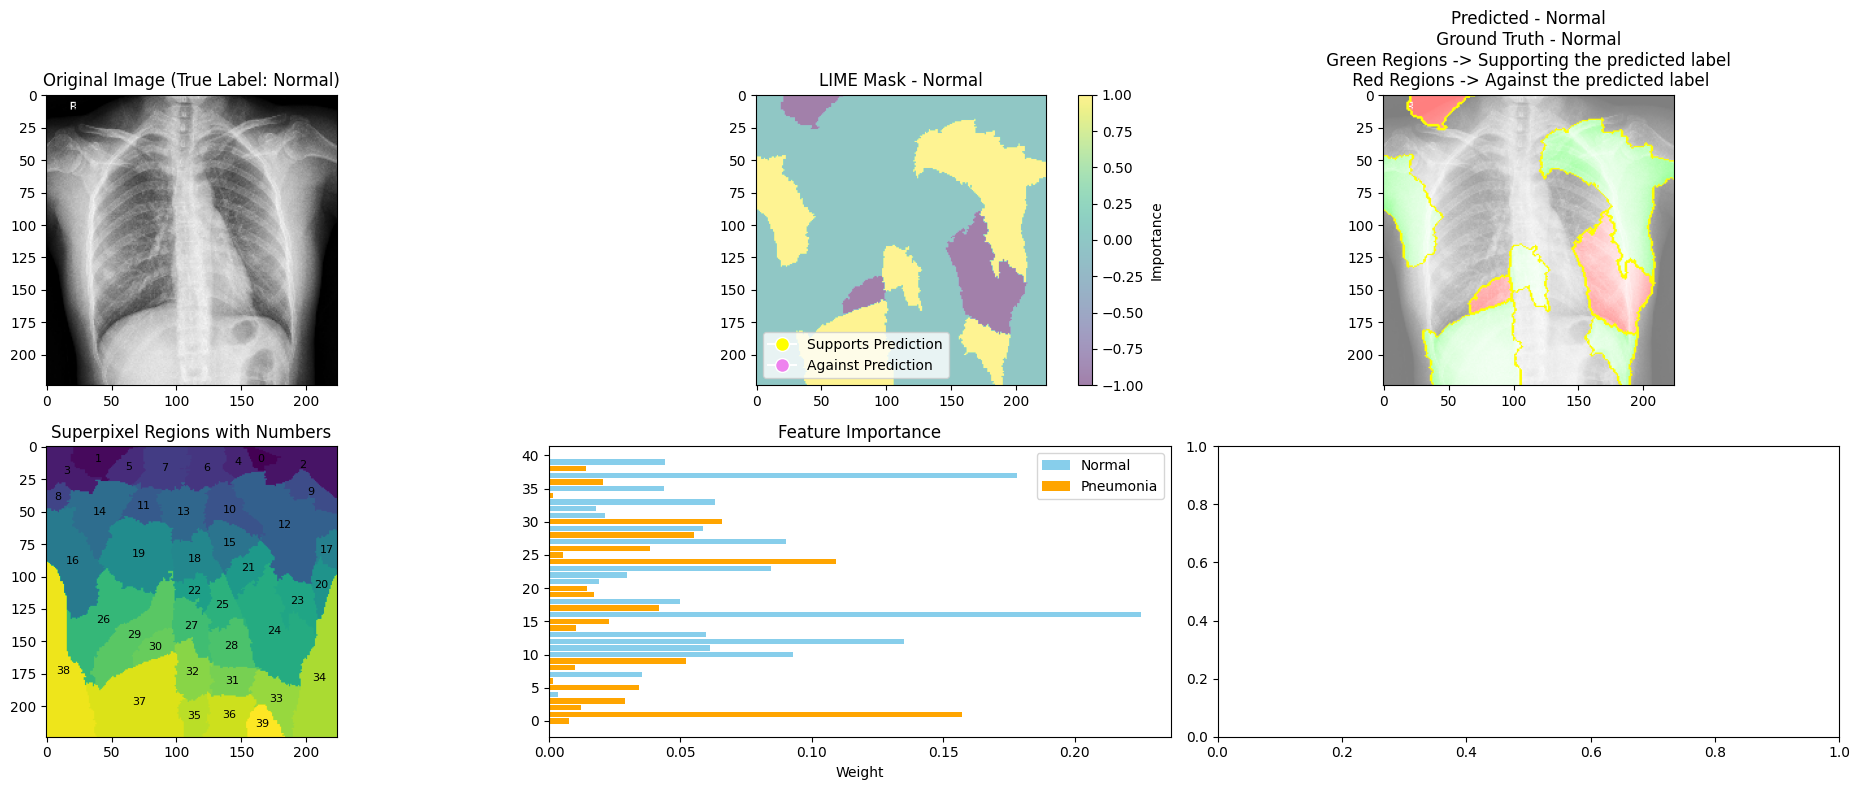

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

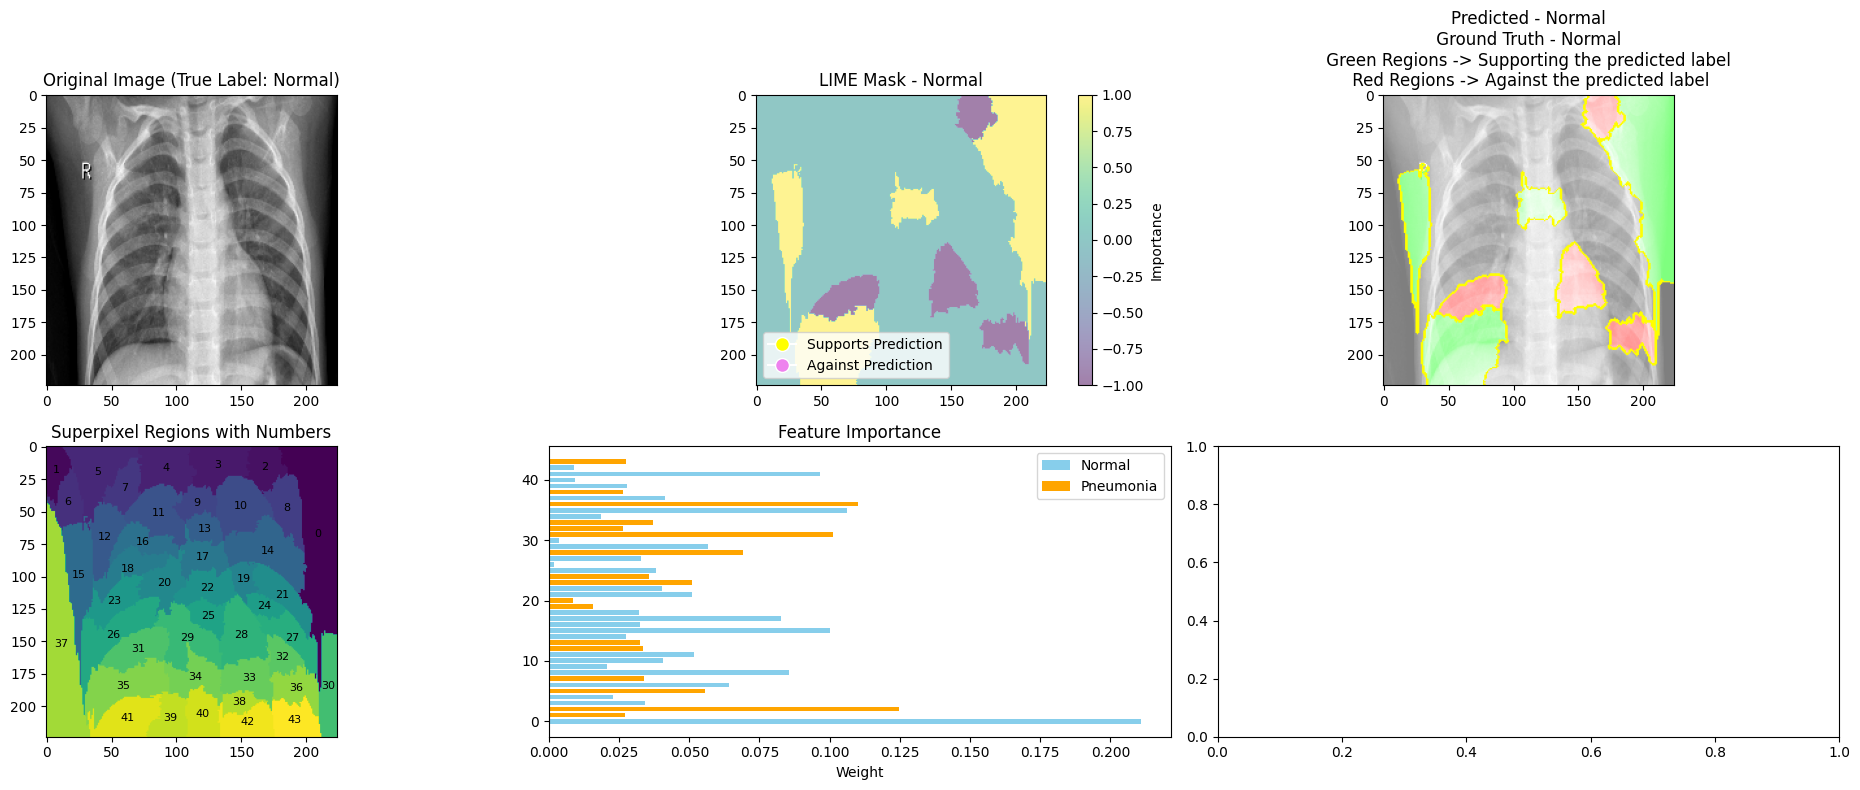

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

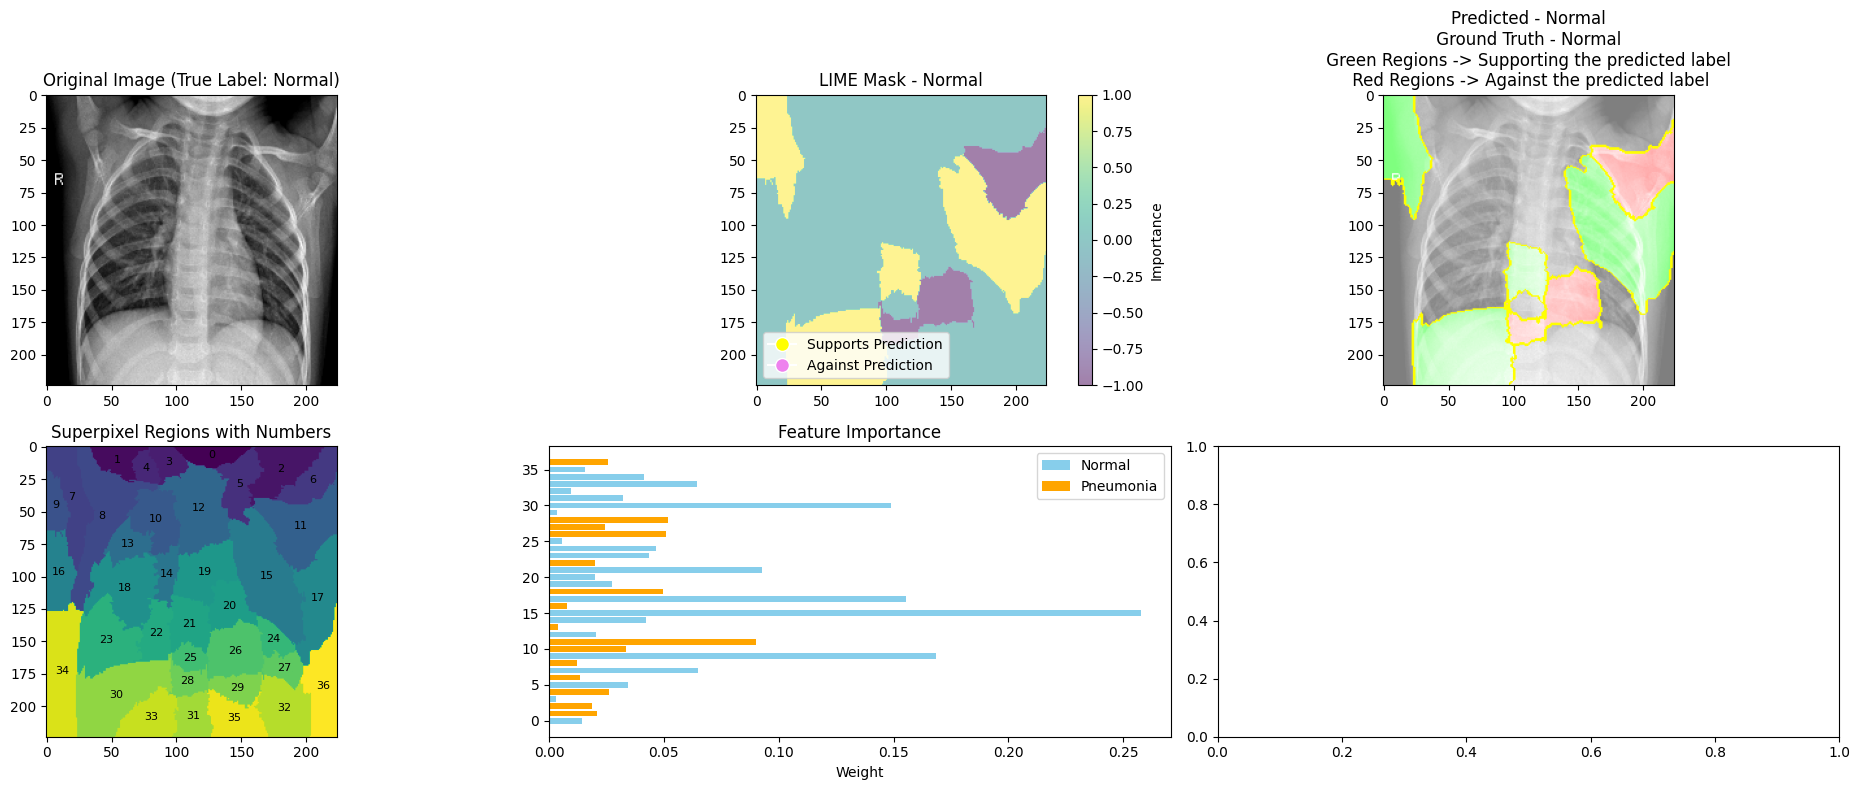

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

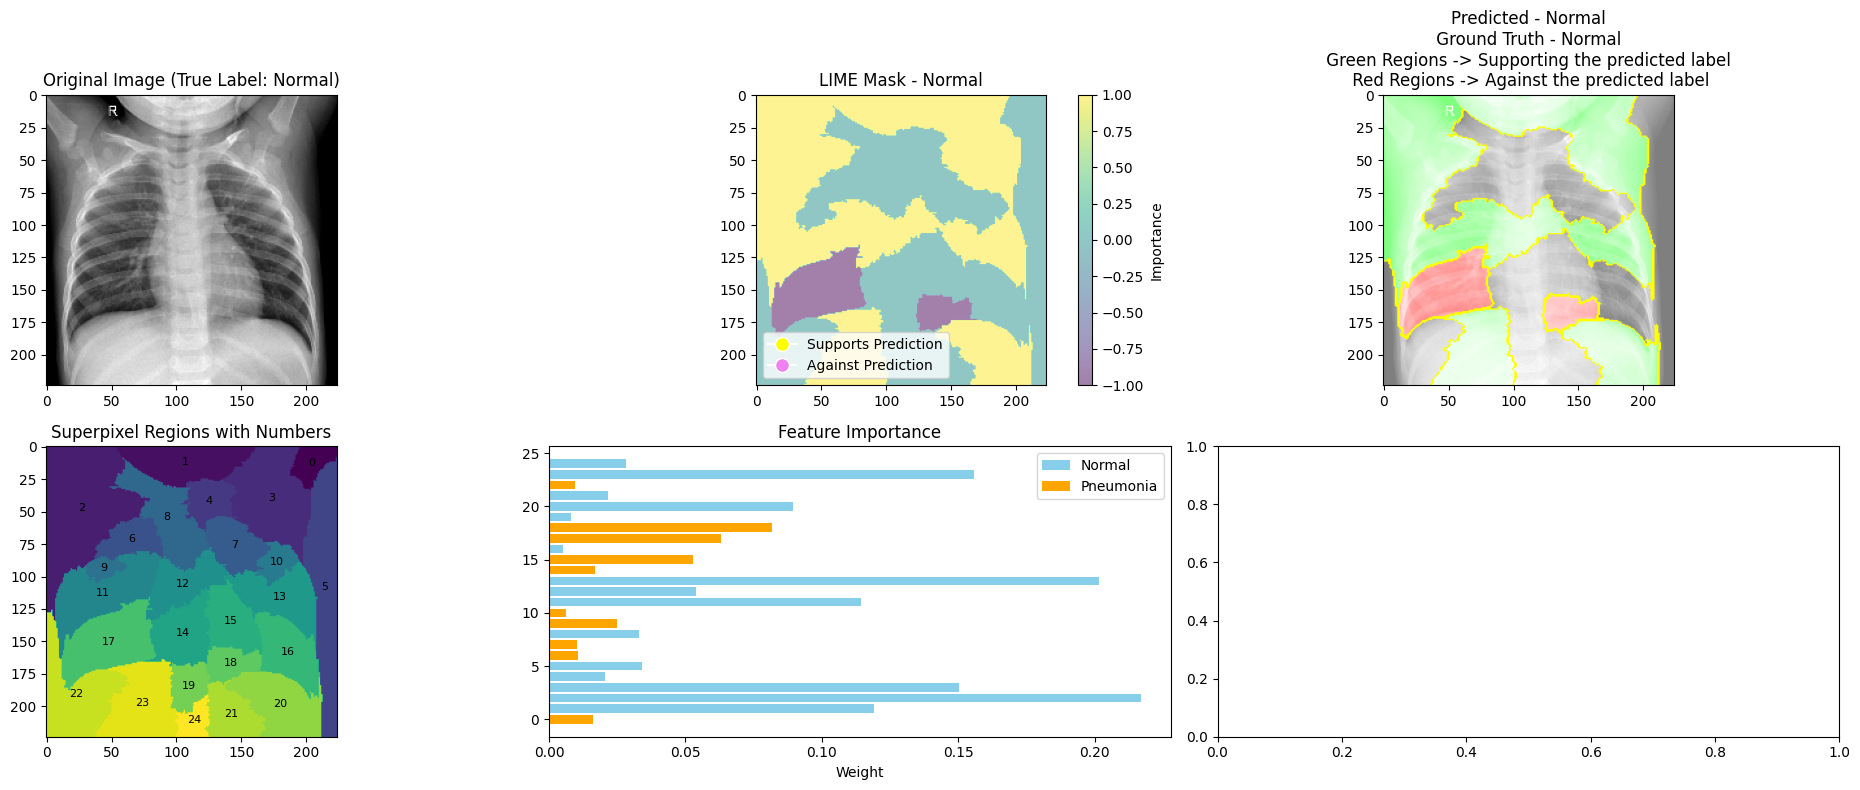

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

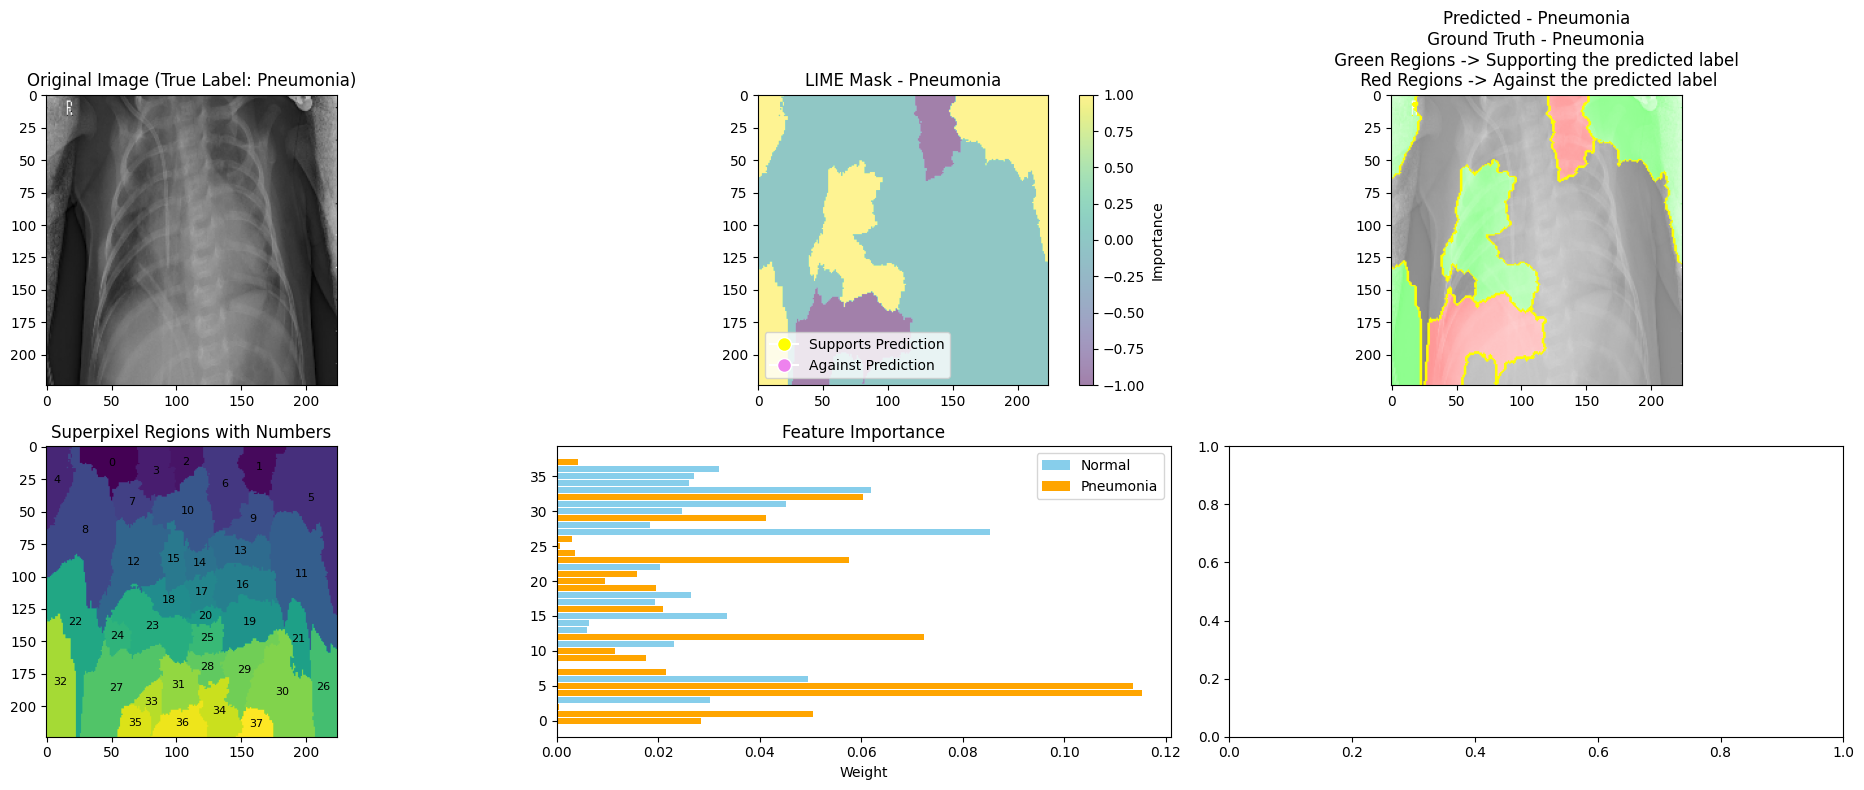

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

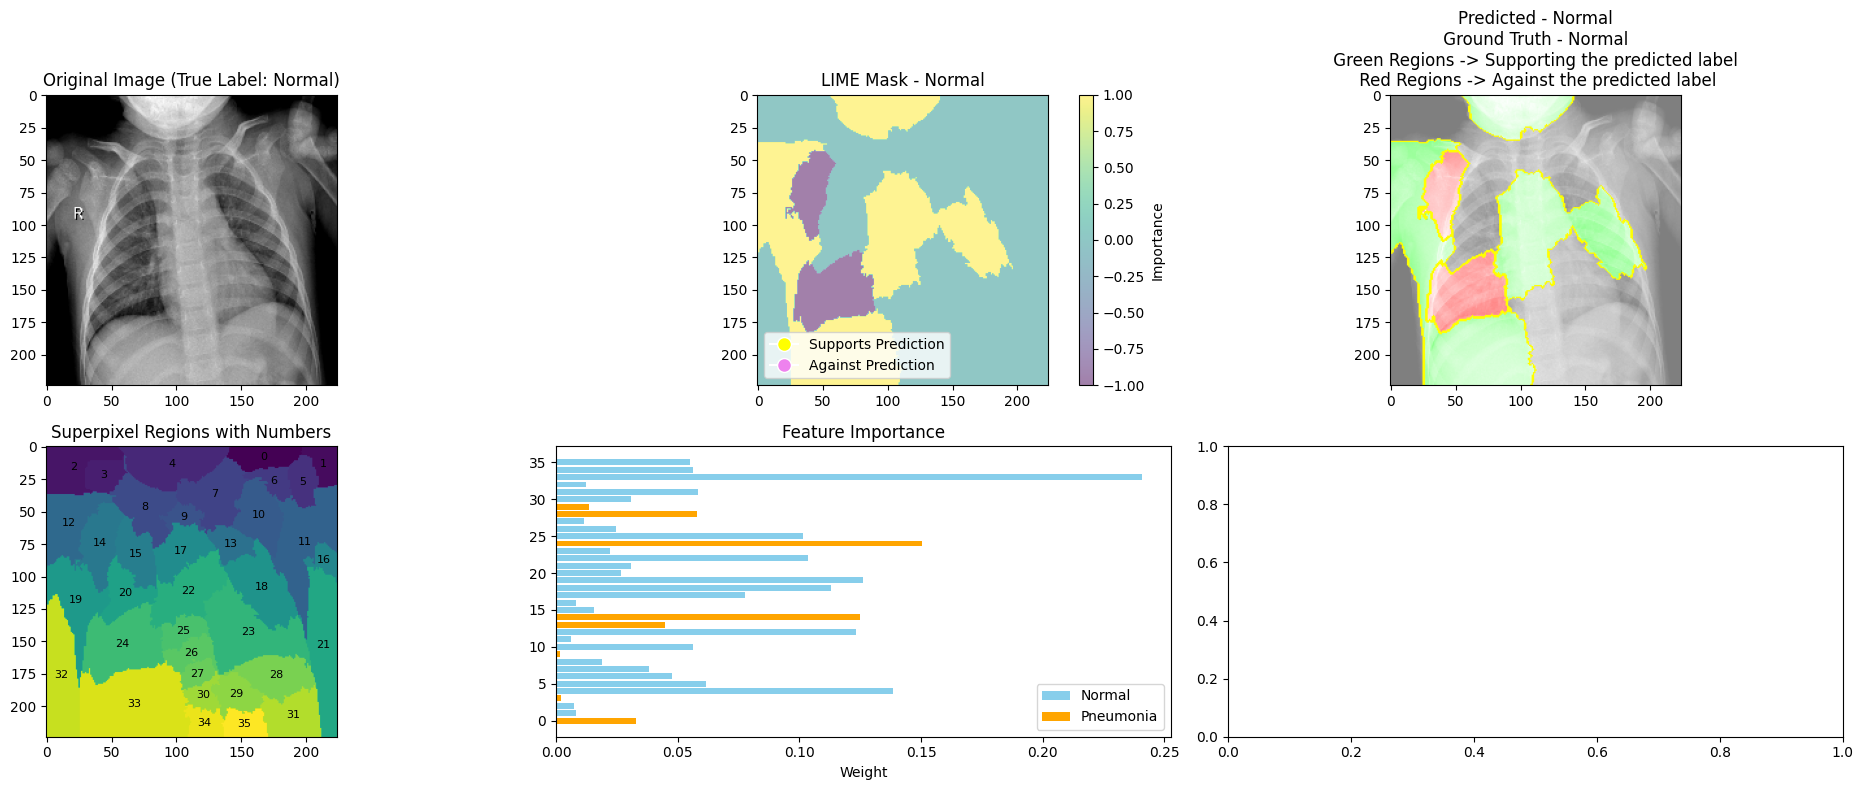

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

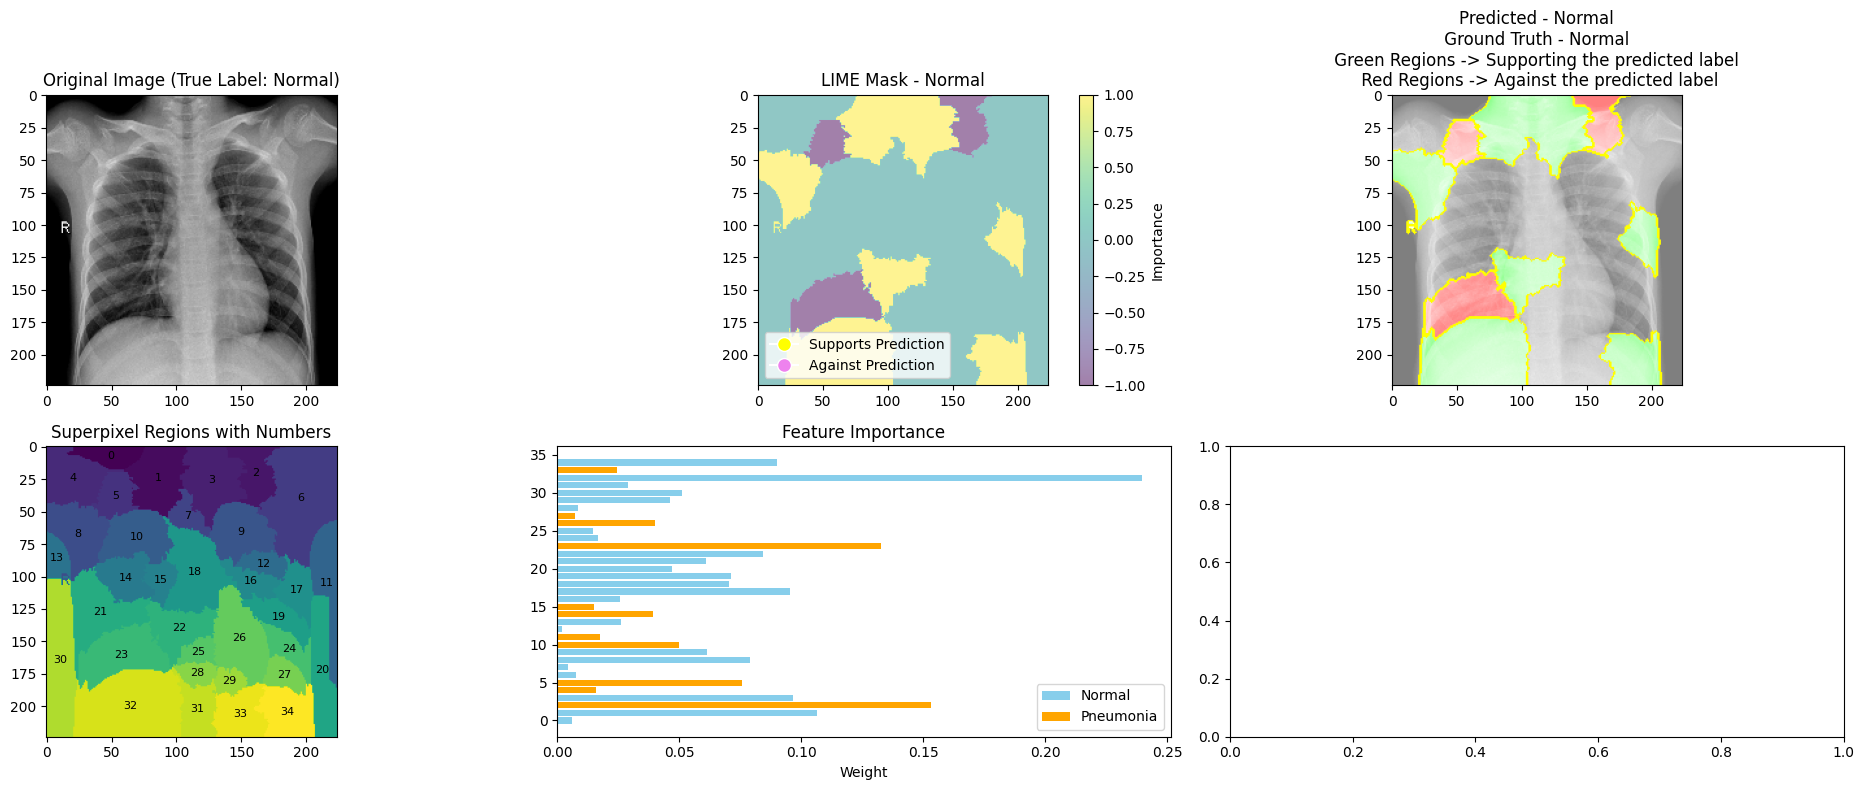

In [19]:
def explain_image(image, index, true_label):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image.astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    
    # Create a figure with 2 rows and 5 columns
    fig, axs = plt.subplots(2, 3, figsize=(20, 8))

    # Display the original image
    axs[0, 0].imshow(image)
    axs[0, 0].set_title('Original Image (True Label: {})'.format(true_label))

    # Display the LIME mask with color representation and labels
    cmap = 'viridis'
    mask_image = axs[0, 1].imshow(mask, cmap=cmap, alpha=0.5)
    axs[0, 1].set_title("LIME Mask - {}".format('Normal' if y_pred_scaled[index] == 0 else 'Pneumonia'))
    colorbar = plt.colorbar(mask_image, ax=axs[0, 1])
    colorbar.set_label('Importance')
    
    # Add legend to the mask image
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Supports Prediction', markerfacecolor='yellow', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Against Prediction', markerfacecolor='violet', markersize=10)]
    axs[0, 1].legend(handles=legend_elements, loc='lower left')
    
    
    # Display the combined image with boundaries
    axs[0, 2].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    axs[0, 2].set_title('Predicted - ' + str('Normal' if y_pred_scaled[index] == 0 else 'Pneumonia') + '\n Ground Truth - ' + str('Normal' if y_test_scaled[index] == 0 else 'Pneumonia')
             + ' \n Green Regions -> Supporting the predicted label \n Red Regions -> Against the predicted label')
    
    # Display the superpixel regions with numbers
    superpixel_regions = explanation.segments
    axs[1, 0].imshow(superpixel_regions, cmap='viridis')
    axs[1, 0].set_title('Superpixel Regions with Numbers')
    
    for segment_num in np.unique(superpixel_regions):
        y, x = np.where(superpixel_regions == segment_num)
        axs[1, 0].text(np.mean(x), np.mean(y), str(segment_num), color='black', ha='center', va='center', fontsize=8)

    # Generate a bar plot for features and their weights
    features_normal = [f[0] for f in explanation.local_exp[0] if f[1] > 0]  # Only positive contributions
    weights_normal = [f[1] for f in explanation.local_exp[0] if f[1] > 0]

    features_pneumonia = [f[0] for f in explanation.local_exp[1] if f[1] > 0]  # Only positive contributions
    weights_pneumonia = [f[1] for f in explanation.local_exp[1] if f[1] > 0]

    axs[1, 1].barh(features_normal, weights_normal, color='skyblue', label='Normal')
    axs[1, 1].barh(features_pneumonia, weights_pneumonia, color='orange', label='Pneumonia')
    axs[1, 1].set_xlabel('Weight')
    axs[1, 1].set_title('Feature Importance')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()
    return explanation

# Assuming you have model, X_test_scaled, y_pred_scaled, and y_test_scaled defined
for index, img in enumerate(X_test_scaled[:10]):
    true_label = 'Normal' if y_test_scaled[index] == 0 else 'Pneumonia'
    explain_image(img, index, true_label)


### def perturb_image(image):
    # Add random noise to the image
    perturbed_image = image + np.random.normal(0, 0.1, image.shape)
    return perturbed_image

def explain_image(image, index, true_label):
    explainer = lime_image.LimeImageExplainer()
    
    # Create a single perturbed image using perturb_image function
    perturbed_image = perturb_image(image)
    
    # Use explain_instance with the perturbed image
    explanation = explainer.explain_instance(
        perturbed_image.astype('double'), 
        model.predict, 
        top_labels=5, 
        hide_color=0, 
        num_samples=1000,
        num_features=10  # Adjust the number of features as needed
    )
    
    # Rest of the code remains unchanged...


    
    # Create a figure with 2 rows and 5 columns
    fig, axs = plt.subplots(2, 3, figsize=(20, 8))

    # Display the original image
    axs[0, 0].imshow(image)
    axs[0, 0].set_title('Original Image (True Label: {})'.format(true_label))

    # Display the LIME mask with color representation and labels
    cmap = 'viridis'
    mask_image = axs[0, 1].imshow(explanation.segments, cmap=cmap, alpha=0.5)
    axs[0, 1].set_title("LIME Mask - {}".format('Normal' if y_pred_scaled[index] == 0 else 'Pneumonia'))
    colorbar = plt.colorbar(mask_image, ax=axs[0, 1])
    colorbar.set_label('Importance')
    
    # Add legend to the mask image
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Supports Prediction', markerfacecolor='yellow', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Against Prediction', markerfacecolor='violet', markersize=10)]
    axs[0, 1].legend(handles=legend_elements, loc='lower left')
    
    # Display the combined image with boundaries
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    axs[0, 2].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    axs[0, 2].set_title('Predicted - ' + str('Normal' if y_pred_scaled[index] == 0 else 'Pneumonia') + '\n Ground Truth - ' + str('Normal' if y_test_scaled[index] == 0 else 'Pneumonia')
             + ' \n Green Regions -> Supporting the predicted label \n Red Regions -> Against the predicted label')
    
    # Display the superpixel regions with numbers
    superpixel_regions = explanation.segments
    axs[1, 0].imshow(superpixel_regions, cmap='viridis')
    axs[1, 0].set_title('Superpixel Regions with Numbers')
    
    for segment_num in np.unique(superpixel_regions):
        y, x = np.where(superpixel_regions == segment_num)
        axs[1, 0].text(np.mean(x), np.mean(y), str(segment_num), color='black', ha='center', va='center', fontsize=8)

    # Generate a bar plot for features and their weights
    features_normal = [f[0] for f in explanation.local_exp[0] if f[1] > 0]  # Only positive contributions
    weights_normal = [f[1] for f in explanation.local_exp[0] if f[1] > 0]

    features_pneumonia = [f[0] for f in explanation.local_exp[1] if f[1] > 0]  # Only positive contributions
    weights_pneumonia = [f[1] for f in explanation.local_exp[1] if f[1] > 0]

    axs[1, 1].barh(features_normal, weights_normal, color='skyblue', label='Normal')
    axs[1, 1].barh(features_pneumonia, weights_pneumonia, color='orange', label='Pneumonia')
    axs[1, 1].set_xlabel('Weight')
    axs[1, 1].set_title('Feature Importance')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()
    return explanation
    
    # Assuming you have model, X_test_scaled, y_pred_scaled, and y_test_scaled defined
for index, img in enumerate(X_test_scaled[:10]):
    true_label = 'Normal' if y_test_scaled[index] == 0 else 'Pneumonia'
    explain_image(img, index, true_label)
